<a href="https://colab.research.google.com/github/Mithunmick/Lane-Line-Detction/blob/main/Lane_Line_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Mithunmick/Lane-Line-Detction.git

Cloning into 'Lane-Line-Detction'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 12 (delta 0), reused 9 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (12/12), 356.96 KiB | 3.40 MiB/s, done.


This code performs DCT-based image compression on the input image, saves the compressed image, displays the original and compressed images, and calculates PSNR and bit rate reduction.

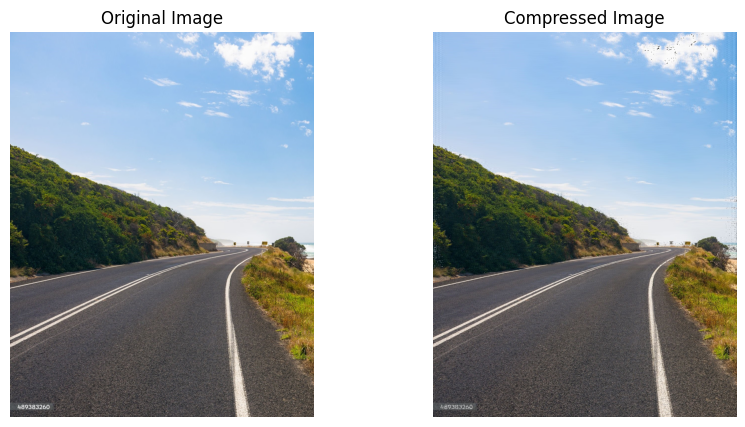

PSNR: 29.70 dB
Bit Rate Reduction: 22.58%
Encoded data length: 350675 bytes
Estimated entropy: 7.33 bits/pixel


In [ ]:
import numpy as np
import cv2
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt
import os

# Define the quantization matrices
Q50 = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
  ])
Q75 = np.array([
    [20, 1, 7, 9, 4, 2, 0, 2],
    [4, 13, -3, 0, 1, 1, 0, 0],
    [-19, -6, 2, -9, -3, -1, 0, 0],
    [-9, -14, -1, -1, 2, 1, -1, 0],
    [2, 4, -3, -1, 0, 0, 0, 0],
    [-1, 4, -1, 0, 0, 1, 1, 1],
    [2, 0, 0, 1, 0, 0, 0, 1],
    [-2, 0, 0, -2, 1, 0, 0, 0]
])

# Function to perform quantization
def quantize(block, q_matrix):
    return (block / q_matrix).round().astype(np.int32)

# Function to perform dequantization
def dequantize(block, q_matrix):
    return (block * q_matrix).astype(np.int32)

# Function to perform 2D DCT
def dct2(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

# Function to perform 2D inverse DCT
def idct2(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

# Function to calculate PSNR
def calculate_psnr(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:
        return 100
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

# Function to calculate entropy
def calculate_entropy(image):
    flattened_image = image.flatten()
    pixel_counts = np.bincount(flattened_image)
    pixel_probabilities = pixel_counts / len(flattened_image)
    non_zero_probabilities = pixel_probabilities[pixel_probabilities != 0]
    entropy = -np.sum(non_zero_probabilities * np.log2(non_zero_probabilities))
    return entropy


# Function to calculate bit rate reduction
def calculate_bit_rate_reduction(original_path, compressed_path):
    original_size = os.path.getsize(original_path)
    compressed_size = os.path.getsize(compressed_path)
    reduction_percentage = ((original_size - compressed_size) / original_size) * 100
    return reduction_percentage

# Read the image using OpenCV
input_image = cv2.imread("/content/Test1 (3).jpg", cv2.IMREAD_COLOR)

# Check if the image was loadconed successfully
if input_image is None:
    print("Error: Image not found or unable to read.")
else:
    # Convert image to YCrCb color space
    ycrcb_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2YCrCb)

    # Extract the Y (luminance) channel
    Y_channel = ycrcb_image[:, :, 0]

    # Pad the Y channel so that its dimensions are multiples of 8
    height, width = Y_channel.shape
    padded_height = height + (8 - height % 8) % 8
    padded_width = width + (8 - width % 8) % 8
    padded_Y_channel = np.pad(Y_channel, ((0, padded_height - height), (0, padded_width - width)), mode='constant', constant_values=0)

    # Perform DCT on 8x8 blocks
    image_dct = np.array([dct2(block) for block in padded_Y_channel.reshape(-1, 8, 8)])

    # Quantize the DCT coefficients
    quantized_coefficients = quantize(image_dct, Q50)

    # Dequantize the coefficients
    dequantized_coefficients = dequantize(quantized_coefficients, Q50)

    # Perform the inverse DCT
    image_reconstructed = np.array([idct2(block) for block in dequantized_coefficients])

    # Reshape and crop the reconstructed Y channel to original dimensions
    reconstructed_Y_channel = image_reconstructed.reshape(padded_Y_channel.shape)[:height, :width]

    # Replace the Y channel in the YCrCb image with the reconstructed Y channel
    ycrcb_image[:, :, 0] = reconstructed_Y_channel

    # Convert back to BGR color space
    compressed_image = cv2.cvtColor(ycrcb_image, cv2.COLOR_YCrCb2BGR)

    # Save the compressed image
    cv2.imwrite('compressed_image.jpg', compressed_image, [int(cv2.IMWRITE_JPEG_QUALITY), 80])


    # Display the original and compressed images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(compressed_image, cv2.COLOR_BGR2RGB))
    plt.title('Compressed Image')
    plt.axis('off')

    plt.show()

    # Calculate and print PSNR value
    psnr_value = calculate_psnr(Y_channel, reconstructed_Y_channel)
    print(f"PSNR: {psnr_value:.2f} dB")

    # Calculate and print bit rate reduction
    bit_rate_reduction = calculate_bit_rate_reduction("/content/Test1 (3).jpg", "compressed_image.jpg")
    print(f"Bit Rate Reduction: {bit_rate_reduction:.2f}%")

    # Measure code length
    encoded_data_length = os.path.getsize("compressed_image.jpg")
    print(f"Encoded data length: {encoded_data_length} bytes")

    # Estimate entropy
    entropy_estimate = calculate_entropy(Y_channel)
    print(f"Estimated entropy: {entropy_estimate:.2f} bits/pixel")




In [ ]:
import math

def grayscale(img):

    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):

    #defining a blank mask to start with
    mask = np.zeros_like(img)

    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    #filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):

    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def slope_lines(image,lines):

    img = image.copy()
    poly_vertices = []
    order = [0,1,3,2]

    left_lines = [] # Like /
    right_lines = [] # Like \
    for line in lines:
        for x1,y1,x2,y2 in line:

            if x1 == x2:
                pass #Vertical Lines
            else:
                m = (y2 - y1) / (x2 - x1)
                c = y1 - m * x1

                if m < 0:
                    left_lines.append((m,c))
                elif m >= 0:
                    right_lines.append((m,c))

    left_line = np.mean(left_lines, axis=0)
    right_line = np.mean(right_lines, axis=0)

    #print(left_line, right_line)

    for slope, intercept in [left_line, right_line]:

        #getting complete height of image in y1
        rows, cols = image.shape[:2]
        y1= int(rows) #image.shape[0]

        #taking y2 upto 60% of actual height or 60% of y1
        y2= int(rows*0.6) #int(0.6*y1)

        #we know that equation of line is y=mx +c so we can write it x=(y-c)/m
        x1=int((y1-intercept)/slope)
        x2=int((y2-intercept)/slope)
        poly_vertices.append((x1, y1))
        poly_vertices.append((x2, y2))
        draw_lines(img, np.array([[[x1,y1,x2,y2]]]))

    poly_vertices = [poly_vertices[i] for i in order]
    cv2.fillPoly(img, pts = np.array([poly_vertices],'int32'), color = (0,255,0))
    return cv2.addWeighted(image,0.7,img,0.4,0.)

    #cv2.polylines(img,np.array([poly_vertices],'int32'), True, (0,0,255), 10)
    #print(poly_vertices)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):

    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    #draw_lines(line_img, lines)
    line_img = slope_lines(line_img,lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.1, β=1., γ=0.):

    lines_edges = cv2.addWeighted(initial_img, α, img, β, γ)
    #lines_edges = cv2.polylines(lines_edges,get_vertices(img), True, (0,0,255), 10)
    return lines_edges
def get_vertices(image):
    rows, cols = image.shape[:2]
    bottom_left  = [cols*0.15, rows]
    top_left     = [cols*0.45, rows*0.6]
    bottom_right = [cols*0.95, rows]
    top_right    = [cols*0.55, rows*0.6]

    ver = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return ver

In [ ]:
# Lane finding Pipeline
def lane_finding_pipeline(image):

    #Grayscale
    gray_img = grayscale(image)
    #Gaussian Smoothing
    smoothed_img = gaussian_blur(img = gray_img, kernel_size = 5)
    #Canny Edge Detection
    canny_img = canny(img = smoothed_img, low_threshold = 180, high_threshold = 240)
    #Masked Image Within a Polygon
    masked_img = region_of_interest(img = canny_img, vertices = get_vertices(image))
    #Hough Transform Lines
    houghed_lines = hough_lines(img = masked_img, rho = 1, theta = np.pi/180, threshold = 20, min_line_len = 20, max_line_gap = 180)
    #Draw lines on edges
    output = weighted_img(img = houghed_lines, initial_img = image, α=0.8, β=1., γ=0.)



    return output

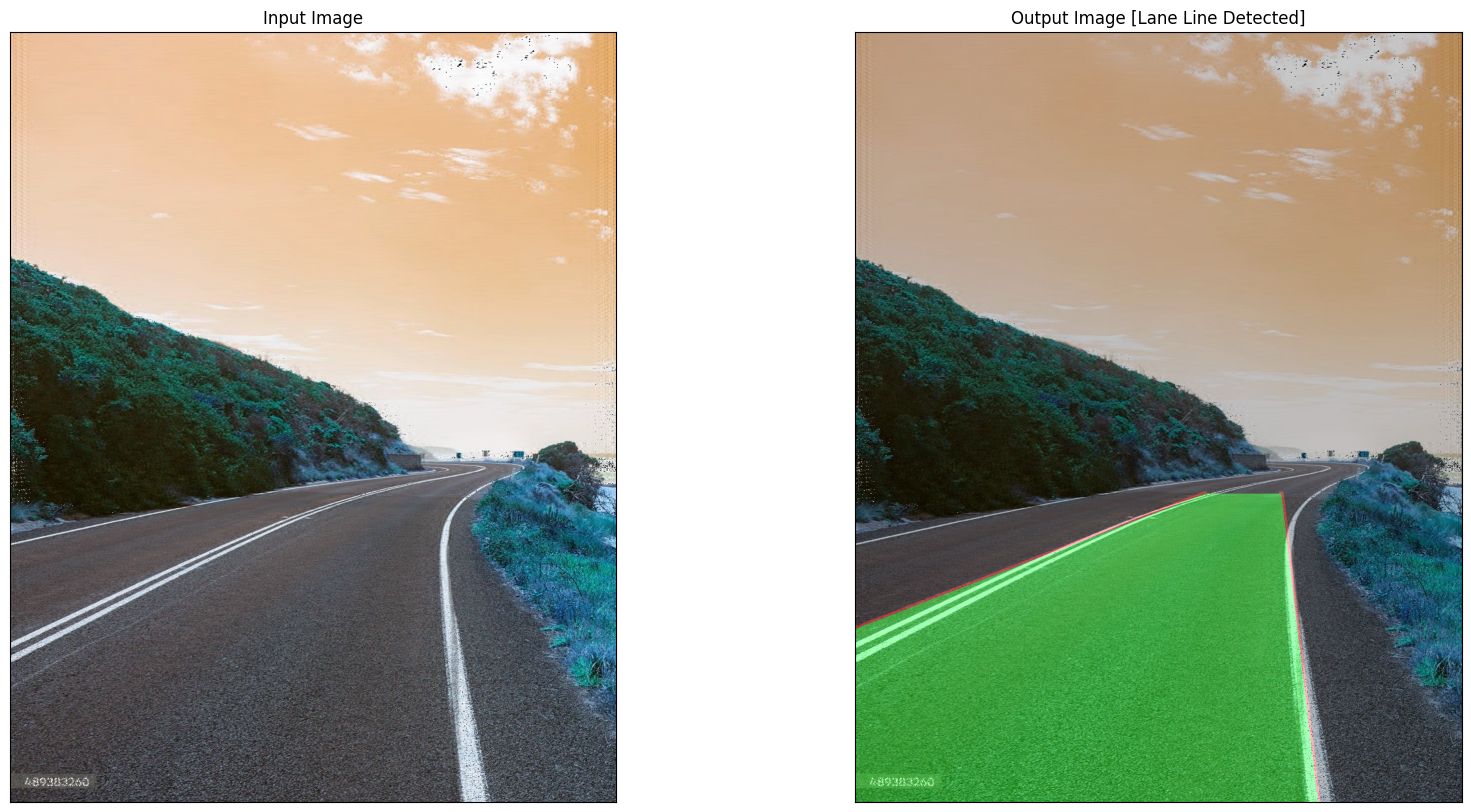

In [ ]:
import matplotlib.image as mpimg  # Import mpimg

fig = plt.figure(figsize=(20, 10))
image = mpimg.imread('/content/compressed_image.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGRA2RGB)
image = image.astype(np.uint8)
ax = fig.add_subplot(1, 2, 1,xticks=[], yticks=[])
plt.imshow(image)
ax.set_title("Input Image")
ax = fig.add_subplot(1, 2, 2,xticks=[], yticks=[])
plt.imshow(lane_finding_pipeline(image))
ax.set_title("Output Image [Lane Line Detected]")
plt.show()